In [91]:
import os
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from keras.src.models import Sequential
from keras.src.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, RandomFlip, RandomTranslation, RandomZoom, RandomShear, RandomPerspective, RandomRotation, GaussianNoise, RandomCrop, Resizing
from keras.src.optimizers.adam import Adam
from keras.src.losses import BinaryCrossentropy
from keras.src.callbacks import ModelCheckpoint
from keras import backend as K
from keras.models import load_model

In [3]:
dataset, info = tfds.load("pneumonia_mnist", as_supervised=True, with_info=True, split=['train', 'test', 'val'])
train_dataset, val_dataset, test_dataset = dataset

train_dataset = train_dataset.take(800).cache()
val_dataset = val_dataset.take(200).cache()
test_dataset = test_dataset.take(100).cache()

In [4]:
def preprocess(image, label):
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.where(image > 0.5, 1.0, 0.0)

    image = tf.image.central_crop(image, central_fraction=0.85) 

    return image, label


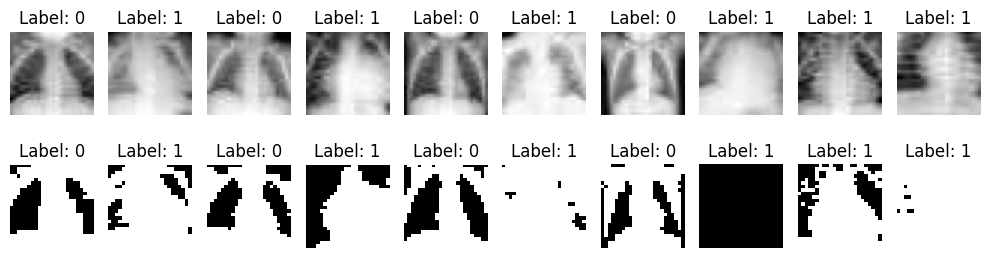

In [5]:
dataset, info = tfds.load("pneumonia_mnist", as_supervised=True, split='train', with_info=True)

samples = list(dataset.take(10))
processed_samples = [preprocess(image, label) for image, label in samples]

plt.figure(figsize=(10, 3))

for i in range(10):
    plt.subplot(2, 10, i + 1)
    plt.imshow(samples[i][0].numpy().squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(f"Label: {samples[i][1].numpy()}")

    plt.subplot(2, 10, i + 11)
    plt.imshow(processed_samples[i][0].numpy().squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(f"Label: {processed_samples[i][1].numpy()}")

plt.tight_layout()
plt.show()


In [6]:
train_dataset_before = train_dataset.batch(32).shuffle(1000)
val_dataset_before = val_dataset.batch(32)
test_dataset_before = test_dataset.batch(32)

train_dataset_preprocessed = train_dataset.map(preprocess)
val_dataset_after = val_dataset.map(preprocess).batch(32)
test_dataset_after = test_dataset.map(preprocess).batch(32)

In [7]:
data_augmentation = Sequential([
    RandomFlip("horizontal"), 
    RandomTranslation(height_factor=0.15, width_factor=0.1),
    RandomZoom(height_factor=0.1, width_factor=0.1), 
])

def augment(image, label):
    image = data_augmentation(image) 
    return image, label

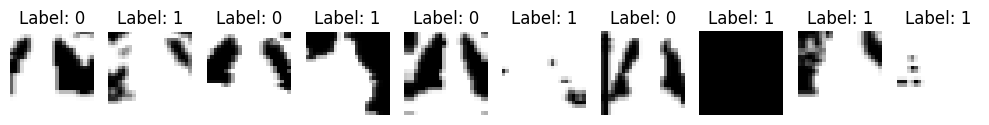

In [8]:
samples = list(train_dataset_preprocessed.take(10))
augmented_samples = [augment(image, label) for image, label in samples]

plt.figure(figsize=(10, 6))

for i in range(10):
    plt.subplot(2, 10, i + 11)
    plt.imshow(augmented_samples[i][0].numpy().squeeze(), cmap='gray')
    plt.axis('off')
    plt.title(f"Label: {processed_samples[i][1].numpy()}")

plt.tight_layout()
plt.show()

In [9]:
train_dataset_after = train_dataset_preprocessed.map(augment).batch(32).shuffle(1000)

In [10]:
def build_model(width, height):
    model = Sequential([
        Input(shape=(width, height, 1)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])
    return model

In [77]:
def cnn_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(1, activation='sigmoid') 
    ])
    model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])
    return model

In [12]:
K.clear_session()
before_checkpoint_cb = ModelCheckpoint(
    filepath='model_before_checkpoint.h5', 
    save_best_only=True,              
    monitor='val_accuracy',             
    mode='max',                      
    save_weights_only=False,          
    verbose=1                         
)

In [13]:
K.clear_session()
after_checkpoint_cb = ModelCheckpoint(
    filepath='model_after_checkpoint.h5', 
    save_best_only=True,              
    monitor='val_accuracy',             
    mode='max',                      
    save_weights_only=False,          
    verbose=1                         
)

In [85]:
K.clear_session()
cnn_checkpoint_cb = ModelCheckpoint(
    filepath='model_cnn_checkpoint.h5', 
    save_best_only=True,              
    monitor='val_accuracy',             
    mode='max',                      
    save_weights_only=False,          
    verbose=1                         
)

In [15]:
model_before = build_model(28, 28)
history1 = model_before.fit(train_dataset_before, epochs=100, validation_data=val_dataset_before, callbacks=[before_checkpoint_cb])

Epoch 1/100
19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6154 - loss: 20.6726
Epoch 1: val_accuracy improved from -inf to 0.81000, saving model to model_before_checkpoint.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.6286 - loss: 17.7351 - val_accuracy: 0.8100 - val_loss: 1.0172
Epoch 2/100
17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7587 - loss: 1.8827 
Epoch 2: val_accuracy did not improve from 0.81000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7815 - loss: 1.6459 - val_accuracy: 0.8100 - val_loss: 1.6966
Epoch 3/100
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8788 - loss: 0.6108 
Epoch 3: val_accuracy did not improve from 0.81000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8766 - loss: 0.6246 - val_accuracy: 0.7100 - val_loss: 3.1690
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8472 - loss: 0.7790 
Epoch 4: val_accuracy improved from 0.81000 to 0.85000, saving model to model_before_checkpoint.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8484 - loss: 0.7709 - val_accuracy: 0.8500 - val_loss: 0.8843
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9065 - loss: 0.3579 
Epoch 5: val_accuracy improved from 0.85000 to 0.85500, saving model to model_before_checkpoint.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9069 - loss: 0.3570 - val_accuracy: 0.8550 - val_loss: 0.7875
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9320 - loss: 0.2939 
Epoch 6: val_accuracy improved from 0.85500 to 0.89000, saving model to model_before_checkpoint.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9317 - loss: 0.2944 - val_accuracy: 0.8900 - val_loss: 0.5374
Epoch 7/100
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9111 - loss: 0.3150
Epoch 7: val_accuracy did not improve from 0.89000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9122 - loss: 0.3189 - val_accuracy: 0.8500 - val_loss: 0.7250
Epoch 8/100
14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9209 - loss: 0.2048 
Epoch 8: val_accuracy did not improve from 0.89000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9212 - loss: 0.2129 - val_accuracy: 0.8100 - val_loss: 1.1773
Epoch 9/100
17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8659 - loss: 0.6519 
Epoch 9: val_accuracy did not improve from 0.89000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8666 - loss: 0.6611 - val_accuracy: 0.8500 - val_loss: 0.7255
Epoch 10/100
17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8861 - loss: 0.4725 
Epoch 10: val_accuracy did not improve from

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8777 - loss: 0.3726 - val_accuracy: 0.8950 - val_loss: 0.5500
Epoch 30/100
15/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9040 - loss: 0.4557 
Epoch 30: val_accuracy improved from 0.89500 to 0.90500, saving model to model_before_checkpoint.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9090 - loss: 0.3994 - val_accuracy: 0.9050 - val_loss: 0.4194
Epoch 31/100
18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9367 - loss: 0.2426 
Epoch 31: val_accuracy did not improve from 0.90500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9406 - loss: 0.2217 - val_accuracy: 0.8500 - val_loss: 0.6945
Epoch 32/100
18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9408 - loss: 0.1941 
Epoch 32: val_accuracy did not improve from 0.90500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9399 - loss: 0.1931 - val_accuracy: 0.8800 - val_loss: 0.4955
Epoch 33/100
14/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9568 - loss: 0.1246 
Epoch 33: val_accuracy did not improve from 0.90500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9613 - loss: 0.1118 - val_accuracy: 0.8700 - val_loss: 0.4329
Epoch 34/100
19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9435 - loss: 0.1966 
Epoch 34: val_accuracy did not impro

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9694 - loss: 0.0966 - val_accuracy: 0.9100 - val_loss: 0.3566
Epoch 36/100
18/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9178 - loss: 0.3085 
Epoch 36: val_accuracy did not improve from 0.91000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9215 - loss: 0.2836 - val_accuracy: 0.8600 - val_loss: 0.4670
Epoch 37/100
21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9667 - loss: 0.0693 
Epoch 37: val_accuracy did not improve from 0.91000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9667 - loss: 0.0706 - val_accuracy: 0.8650 - val_loss: 0.5215
Epoch 38/100
21/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9462 - loss: 0.1137 
Epoch 38: val_accuracy did not improve from 0.91000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9489 - loss: 0.1105 - val_accuracy: 0.8350 - val_loss: 0.6109
Epoch 39/100
19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9730 - loss: 0.0742 
Epoch 39: val_accuracy did not impro

In [16]:
model_after = build_model(24, 24)
history2 = model_after.fit(train_dataset_after, epochs=100, validation_data=val_dataset_after, callbacks=[after_checkpoint_cb])

Epoch 1/100


23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6884 - loss: 0.5388
Epoch 1: val_accuracy improved from -inf to 0.89500, saving model to model_after_checkpoint.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.6977 - loss: 0.5295 - val_accuracy: 0.8950 - val_loss: 0.3168
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8449 - loss: 0.3333  
Epoch 2: val_accuracy did not improve from 0.89500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8450 - loss: 0.3336 - val_accuracy: 0.8500 - val_loss: 0.3470
Epoch 3/100
 1/25 ━━━━━━━━━━━━━━━━━━━━ 6s 280ms/step - accuracy: 0.8438 - loss: 0.4451
Epoch 3: val_accuracy improved from 0.89500 to 0.90000, saving model to model_after_checkpoint.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8494 - loss: 0.3624 - val_accuracy: 0.9000 - val_loss: 0.2857
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8608 - loss: 0.3265  
Epoch 4: val_accuracy did not improve from 0.90000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8612 - loss: 0.3258 - val_accuracy: 0.8900 - val_loss: 0.2764
Epoch 5/100
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8638 - loss: 0.2880  
Epoch 5: val_accuracy improved from 0.90000 to 0.92000, saving model to model_after_checkpoint.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8649 - loss: 0.2872 - val_accuracy: 0.9200 - val_loss: 0.2544
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8911 - loss: 0.2513  
Epoch 6: val_accuracy did not improve from 0.92000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8913 - loss: 0.2512 - val_accuracy: 0.8750 - val_loss: 0.2967
Epoch 7/100
 1/25 ━━━━━━━━━━━━━━━━━━━━ 6s 287ms/step - accuracy: 0.9062 - loss: 0.2940
Epoch 7: val_accuracy did not improve from 0.92000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8884 - loss: 0.2770 - val_accuracy: 0.9200 - val_loss: 0.2436
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8980 - loss: 0.2742  
Epoch 8: val_accuracy did not improve from 0.92000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8981 - loss: 0.2733 - val_accuracy: 0.9200 - val_loss: 0.2366
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8985 - loss: 0.2660
Epoch 9: val_accuracy improved from 0.920

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8984 - loss: 0.2655 - val_accuracy: 0.9250 - val_loss: 0.2368
Epoch 10/100
24/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9047 - loss: 0.2287  
Epoch 10: val_accuracy did not improve from 0.92500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9051 - loss: 0.2284 - val_accuracy: 0.9150 - val_loss: 0.2338
Epoch 11/100
 1/25 ━━━━━━━━━━━━━━━━━━━━ 7s 297ms/step - accuracy: 0.9062 - loss: 0.1614
Epoch 11: val_accuracy did not improve from 0.92500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9186 - loss: 0.2060 - val_accuracy: 0.8850 - val_loss: 0.2730
Epoch 12/100
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8686 - loss: 0.2957  
Epoch 12: val_accuracy did not improve from 0.92500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8715 - loss: 0.2901 - val_accuracy: 0.8500 - val_loss: 0.3305
Epoch 13/100
 1/25 ━━━━━━━━━━━━━━━━━━━━ 7s 301ms/step - accuracy: 0.9062 - loss: 0.3248
Epoch 13: val_accuracy did not i

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9106 - loss: 0.2215 - val_accuracy: 0.9300 - val_loss: 0.2226
Epoch 28/100
 1/25 ━━━━━━━━━━━━━━━━━━━━ 7s 316ms/step - accuracy: 0.8750 - loss: 0.3061
Epoch 28: val_accuracy did not improve from 0.93000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9189 - loss: 0.2162 - val_accuracy: 0.8950 - val_loss: 0.2599
Epoch 29/100
 1/25 ━━━━━━━━━━━━━━━━━━━━ 6s 278ms/step - accuracy: 0.9375 - loss: 0.1520
Epoch 29: val_accuracy did not improve from 0.93000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9094 - loss: 0.2098 - val_accuracy: 0.9000 - val_loss: 0.2791
Epoch 30/100
 1/25 ━━━━━━━━━━━━━━━━━━━━ 6s 269ms/step - accuracy: 0.9062 - loss: 0.2659
Epoch 30: val_accuracy did not improve from 0.93000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9094 - loss: 0.2144 - val_accuracy: 0.9000 - val_loss: 0.2288
Epoch 31/100
 1/25 ━━━━━━━━━━━━━━━━━━━━ 5s 249ms/step - accuracy: 0.9062 - loss: 0.1844
Epoch 31: val_accuracy did not i

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9171 - loss: 0.2046 - val_accuracy: 0.9350 - val_loss: 0.2147
Epoch 44/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9334 - loss: 0.2036  
Epoch 44: val_accuracy did not improve from 0.93500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9330 - loss: 0.2037 - val_accuracy: 0.9050 - val_loss: 0.2238
Epoch 45/100
 1/25 ━━━━━━━━━━━━━━━━━━━━ 6s 276ms/step - accuracy: 0.9688 - loss: 0.1393
Epoch 45: val_accuracy did not improve from 0.93500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9385 - loss: 0.1729 - val_accuracy: 0.8850 - val_loss: 0.2544
Epoch 46/100
 1/25 ━━━━━━━━━━━━━━━━━━━━ 6s 258ms/step - accuracy: 0.9062 - loss: 0.2232
Epoch 46: val_accuracy did not improve from 0.93500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9259 - loss: 0.1976 - val_accuracy: 0.9350 - val_loss: 0.2136
Epoch 47/100
 1/25 ━━━━━━━━━━━━━━━━━━━━ 7s 301ms/step - accuracy: 0.9375 - loss: 0.1481
Epoch 47: val_accuracy did not i

In [86]:
model_cnn = cnn_model()
history3 = model_cnn.fit(train_dataset_before, epochs=100, validation_data=val_dataset_before, callbacks=[cnn_checkpoint_cb])

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6558 - loss: 3.5135
Epoch 1: val_accuracy improved from -inf to 0.78500, saving model to model_cnn_checkpoint.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6597 - loss: 3.4440 - val_accuracy: 0.7850 - val_loss: 0.5166
Epoch 2/100
22/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8838 - loss: 0.2503
Epoch 2: val_accuracy did not improve from 0.78500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8868 - loss: 0.2462 - val_accuracy: 0.7650 - val_loss: 0.6240
Epoch 3/100
17/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9401 - loss: 0.1395
Epoch 3: val_accuracy did not improve from 0.78500
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9375 - loss: 0.1460 - val_accuracy: 0.7700 - val_loss: 0.7440
Epoch 4/100
19/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9438 - loss: 0.1256
Epoch 4: val_accuracy improved from 0.78500 to 0.88000, saving model to model_cnn_checkpoint.h5


25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9447 - loss: 0.1269 - val_accuracy: 0.8800 - val_loss: 0.2846
Epoch 5/100
20/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9447 - loss: 0.1433
Epoch 5: val_accuracy did not improve from 0.88000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9437 - loss: 0.1415 - val_accuracy: 0.7250 - val_loss: 1.0254
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9477 - loss: 0.1093
Epoch 6: val_accuracy did not improve from 0.88000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9482 - loss: 0.1087 - val_accuracy: 0.8200 - val_loss: 0.4598
Epoch 7/100
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9655 - loss: 0.0804
Epoch 7: val_accuracy did not improve from 0.88000
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.9648 - loss: 0.0803 - val_accuracy: 0.7850 - val_loss: 0.6977
Epoch 8/100
23/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9534 - loss: 0.1230
Epoch 8: val_accuracy did not improve from 

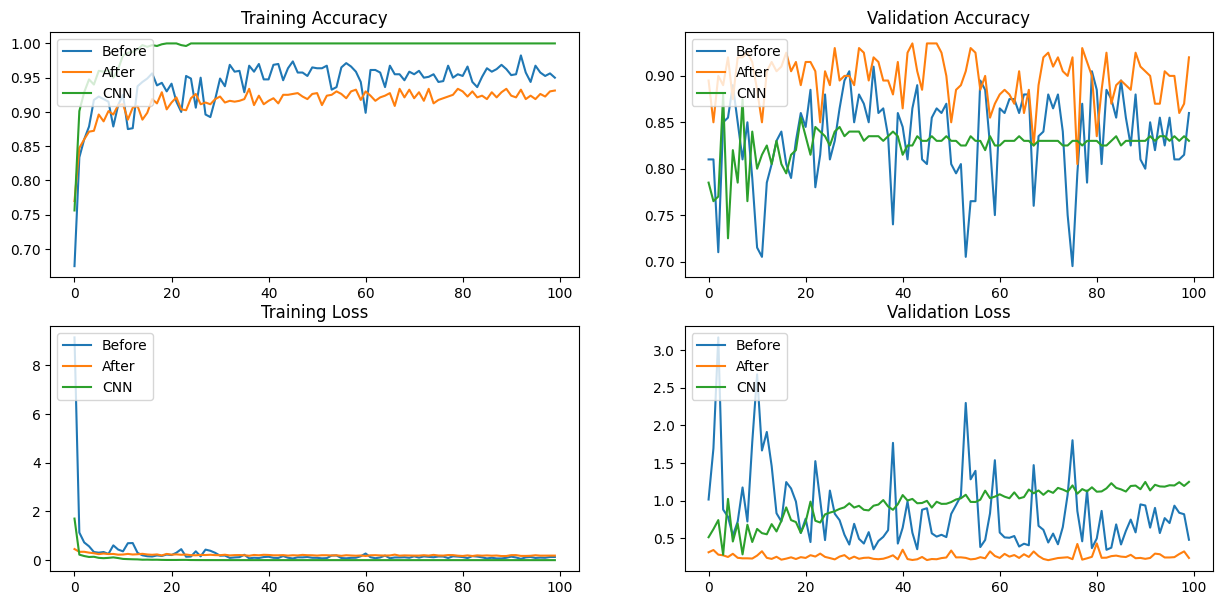

In [88]:
epochs_range1 = range(len(history1.history['accuracy']))
epochs_range2 = range(len(history2.history['accuracy']))
epochs_range3 = range(len(history3.history['accuracy']))

plt.figure(figsize=(15, 7))

plt.subplot(2, 2, 1)
plt.plot(epochs_range1, history1.history['accuracy'], label='Before')
plt.plot(epochs_range2, history2.history['accuracy'], label='After')
plt.plot(epochs_range3, history3.history['accuracy'], label='CNN')
plt.legend(loc='upper left')
plt.title('Training Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range1, history1.history['val_accuracy'], label='Before')
plt.plot(epochs_range2, history2.history['val_accuracy'], label='After')
plt.plot(epochs_range3, history3.history['val_accuracy'], label='CNN')
plt.legend(loc='upper left')
plt.title('Validation Accuracy')

plt.subplot(2, 2, 3)
plt.plot(epochs_range1, history1.history['loss'], label='Before')
plt.plot(epochs_range2, history2.history['loss'], label='After')
plt.plot(epochs_range3, history3.history['loss'], label='CNN')
plt.legend(loc='upper left')
plt.title('Training Loss')

plt.subplot(2, 2, 4)
plt.plot(epochs_range1, history1.history['val_loss'], label='Before')
plt.plot(epochs_range2, history2.history['val_loss'], label='After')
plt.plot(epochs_range3, history3.history['val_loss'], label='CNN')
plt.legend(loc='upper left')
plt.title('Validation Loss')

plt.show()

In [93]:
model_before = load_model('model_before_checkpoint.h5')
model_after = load_model('model_after_checkpoint.h5')
model_cnn = load_model('model_cnn_checkpoint.h5')

loss1, accuracy1 = model_before.evaluate(test_dataset_before)
loss2, accuracy2 = model_after.evaluate(test_dataset_after)
loss3, accuracy3 = model_cnn.evaluate(test_dataset_before)

print(f"Loss Before Preprocessing and Augmentation: {loss1:.4f}")
print(f"Accuracy Before Preprocessing  and Augmentation: {accuracy1:.4f}")
print(f"Loss After Preprocessing and Augmentation: {loss2:.4f}")
print(f"Accuracy After Preprocessing and Augmentation: {accuracy2:.4f}")
print(f"Loss with Custom CNN: {loss3:.4f}")
print(f"Accuracy with Custom CNN: {accuracy3:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8583 - loss: 0.4063  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9355 - loss: 0.2283  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8921 - loss: 0.2855  
Loss Before Preprocessing and Augmentation: 0.3456
Accuracy Before Preprocessing  and Augmentation: 0.8800
Loss After Preprocessing and Augmentation: 0.2271
Accuracy After Preprocessing and Augmentation: 0.9300
Loss with Custom CNN: 0.2597
Accuracy with Custom CNN: 0.9100
